# Checkpointing

Your task is to implement checkpointing for a MLP using NumPy.

You are free to use the implementation of a MLP and the backpropagation algorithm that you have developed during lab sessions.

The key takeaway from this task is that with checkpointing we can trade off the computational resources needed to compute the forward pass of the network for the memory requirement needed to perform a backward pass in the network, which is often a major bottleneck when training large networks. In plain english, we can slightly increase the time required for training our network to save some of our GPU's precious memory.

## What is checkpointing?

The aim of checkpointing is to save every $n$-th layer's (e.g. every 2-nd layer's) forward result (instead of saving every layer's forward result as in plain backpropagation) and use these checkpoints for recomputing the forward pass of the network upon doing a backward pass. Checkpoint layers are kept in memory after the forward pass, while the remaining activations are recomputed at most once. After being recomputed, the non-checkpoint layers are kept in memory until they are no longer required.

# What should be done

1. Take the implementation a MLP trained with backpropagation. Analyze the algorithm with respect to the memory that is used by the algorithm with respect to the number of hidden layers.

2. Implement a class NetworkWithCheckpointing that inherits from the Network class defined during lab sessions by:
    a) implementing a method `forward_between_checkpoints` that will recompute the forward pass of the network using one of the checkpointed layers
    b) override the method `backprop` to use only checkpointed layers and otherwise compute the activations using `forward_between_checkpoints` method and keep it in memory until no longer needed.

3. Train your network with checkpoinintg on MNIST. Compare running times and memory usage with respect to the network without checkpointing.


# Implement Checkpointing for a MLP

In [ ]:
import random
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import itertools
import time
from torchvision import datasets, transforms

In [ ]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2022-11-21 03:39:29--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.128.128, 54.231.140.8, 54.231.166.136, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  12.7MB/s    in 0.9s    

2022-11-21 03:39:31 (12.7 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [ ]:
# Let's read the mnist dataset

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

In [ ]:
from typing import TypeVar, Generic, Tuple, Union, Optional, Callable, List, Any, Dict, Iterable

Shape = TypeVar("Shape")

class NDArray(np.ndarray, Generic[Shape]):
    pass

def print_shapes(*args):
    print("\n", list(map(lambda x: x.shape, args)))

In [ ]:
def sigmoid(z: NDArray['B, N, 1']):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z: NDArray['B, N, 1']):
    return sigmoid(z) * (1 - sigmoid(z))

def softmax(z: NDArray['B, N, 1']):
    denominator = np.sum(np.exp(z), 1)
    squeezed_result: NDArray['B, N'] = np.squeeze(np.exp(z)) / denominator
    return np.expand_dims(squeezed_result, squeezed_result.ndim)

# Base network implementation

Our base network uses softmax as activation of the final layer.

Does not use L2 regularization, momentum, nor dropout

It saves both outputs before and after activation for each layer.

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


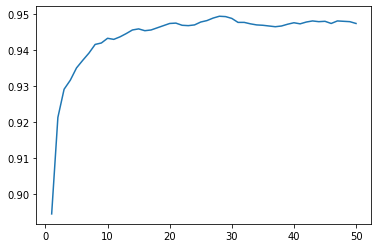

In [ ]:
class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        assert self.num_layers > 0
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        self.hidden_layers_idxes = range(1, self.num_layers)

    def is_last_layer(self, l):
        return l == self.num_layers - 1

    def calculate_before(self, previous_after: NDArray['B, N(l - 1), 1'], w: NDArray['N(l), N(l - 1)'], b: NDArray['N(l)']) -> NDArray['B, N(l), 1']:
        return (w @ previous_after) + b

    def calculate_after(self, l, before: NDArray['B, N(l), 1']) -> NDArray['B, N(l), 1']:
        return softmax(before) if self.is_last_layer(l) else sigmoid(before)

    def forward_step(self, l, previous_after: NDArray['B, N(l - 1), 1'], w: NDArray['N(l), N(l - 1)'], b: NDArray['B, N(l), 1']):
        before = self.calculate_before(previous_after, w, b)
        return self.calculate_after(l, before)

    def calculate_nabla_after(self, weight: NDArray['N(l), N(l - 1)'], nabla_before: NDArray['B, N(l), 1']) -> NDArray['B, N(l - 1), 1']:
        return weight.T @ nabla_before

    def calculate_nabla_b(self, nabla_before: NDArray['B, N(l), 1']) -> NDArray['N(l), 1']:
        return np.sum(nabla_before, 0)

    def calculate_nabla_w(self, nabla_before: NDArray['B, N(l), 1'], previous_after: NDArray['B, N(l - 1), 1']) -> NDArray['N(l), N(l - 1)']:
        return np.squeeze(nabla_before).T @  np.squeeze(previous_after)

    def cost_derivative(self, output_activations: NDArray['B, N(l), 1'], y: NDArray['B, N(l), 1']) -> NDArray['B, N(l), 1']:
        return (output_activations - y)

    def get_outputs_from_forward_pass(self, after: NDArray['B, N(0), 1']):
        afters = [after]
        befores = []
        for l, w, b in zip(self.hidden_layers_idxes, self.weights, self.biases):
            before = self.calculate_before(after, w, b)
            befores.append(before)
            after = self.calculate_after(l, before)
            afters.append(after)
        return afters, befores

    def get_params_deltas_from_backward_pass(self, afters, befores, y):
        # Remove activated output of the last layer
        output = afters.pop()
        nablas_b = []
        nablas_w = []
        for l, biase, weight, before, previous_after in reversed(list(zip(self.hidden_layers_idxes, self.biases, self.weights, befores, afters))):

            # Gradient of loss over output before activation for l-th layer
            nabla_before: NDArray['B, N(l), 1'] = (
                self.cost_derivative(output, y)
                if self.is_last_layer(l)
                else nabla_after * sigmoid_prime(before)
            )

            # Gradient of loss over output after activation for (l - 1)-th layer
            nabla_after = self.calculate_nabla_after(weight, nabla_before)

            # Gradient of biases for l-th layer
            nablas_b.append(self.calculate_nabla_b(nabla_before))

            # Gradient of weights for l-th layer
            nablas_w.append(self.calculate_nabla_w(nabla_before, previous_after))
        return reversed(nablas_b), reversed(nablas_w)

    def backprop(self, x: NDArray['B, N, 1'], y: NDArray['B, N, 1']) -> (
        Tuple[
            Iterable[NDArray['N(l), N(l-1)']], # Weights gradients
            Iterable[NDArray['N(l), N(l-1)']]  # Biases gradients
        ]
    ):
        # Go forward remembering all values before activation for layers 0, ..., L
        # and after activation for layers 1, ..., L
        afters, befores = self.get_outputs_from_forward_pass(x)

        # Go backward from the final cost applying backpropagation
        return self.get_params_deltas_from_backward_pass(afters, befores, y)

    def update_mini_batch(self, x_mini_batch, y_mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch.
        # eta is the learning rate

        nablas_b, nablas_w = self.backprop(x_mini_batch.reshape(-1, 784, 1), y_mini_batch.reshape(-1, 10, 1))
        self.weights = [w - eta / len(x_mini_batch) * nw for w, nw in zip(self.weights, nablas_w)]
        self.biases = [b - eta / len(x_mini_batch) * nb for b, nb in zip(self.biases, nablas_b)]

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data, use_tqdm = True):
        x_train, y_train = training_data
        accuracy = []
        epochs = tqdm.tqdm(range(epochs)) if use_tqdm else range(epochs)
        for j in epochs:
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
                y_mini_batch = y_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
                self.update_mini_batch(x_mini_batch, y_mini_batch, eta)
            if test_data:
                accuracy.append(self.evaluate(test_data))
        if test_data:
            plt.plot(np.arange(1, len(accuracy) + 1), accuracy)

    def feedforward(self, a: NDArray['B, N(0), 1']) -> NDArray['B, N(L), 1']:
        # Run the network on batch of inputs
        for l, b, w in zip(self.hidden_layers_idxes, self.biases, self.weights):
            a = self.forward_step(l, a, w, b)
        return a

    def evaluate(self, test_data: NDArray['2, B, N']):
        x_test_data: NDArray['B, N, 1'] = test_data[0].reshape(-1, 784, 1)
        y_test_data: NDArray['B, N, 1'] = test_data[1].reshape(-1, 10, 1)

        targets: NDArray['B, 1'] = np.argmax(y_test_data, 1)
        test_results: NDArray['B, 1'] = np.argmax(self.feedforward(x_test_data), 1)

        # return accuracy
        return np.mean(targets == test_results)

network = Network([784,30,10])
network.SGD((x_train, y_train), epochs=50, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

# Implementation of network with checkpointing

Checkpointing network saves outputs after activation for every n-th layer.

During backward pass, if encounters the layer $l$ for which there is no saved output after activation, it computates output activations for all layers starting from the nearest layer with checkpoint up to the layer $l$ and saves those outputs in cache.

After particular output is no longer needed it is removed from the cache.

100%|██████████| 50/50 [01:12<00:00,  1.46s/it]


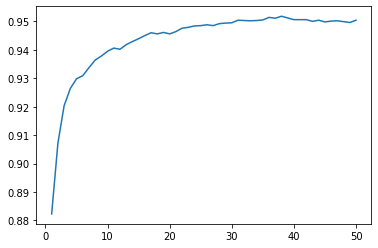

In [ ]:
class NetworkWithCheckpointing(Network):
    def __init__(self, sizes, checkpoint_every_nth_layer: int = 0, *args, **kwargs):
        super().__init__(sizes, *args, **kwargs)
        self.cached_afters: Dict[int, NDArray['B, N, 1']] = dict()
        self.checkpoint_every_nth_layer = checkpoint_every_nth_layer

    def nearest_checkpoint_idx(self, l):
        return l - (l % self.checkpoint_every_nth_layer)

    def forward_up_to_layer(self, layer_idx):
        # Computes outputs after activation for layers with indexes
        # from the interval [nearest_checkpoin_idx(layer_idx), layer_idx]
        nearest_checkpoint_idx = self.nearest_checkpoint_idx(layer_idx)
        output = self.cached_afters.get(nearest_checkpoint_idx)
        for l in range(nearest_checkpoint_idx + 1, layer_idx + 1):
            paremeter_pos_in_list = l - 1
            output = self.forward_step(l, output, self.weights[paremeter_pos_in_list], self.biases[paremeter_pos_in_list])
            self.cached_afters[l] = output

    def get_cached_after_or_calculate(self, l):
        if l not in self.cached_afters:
            self.forward_up_to_layer(l)
        return self.cached_afters.get(l)

    def cache_afters_during_forward_pass(self, after: NDArray['B, N(0), 1']):
        self.cached_afters[0] = after
        for l, w, b in zip(self.hidden_layers_idxes, self.weights, self.biases):
            after = self.forward_step(l, after, w, b)
            if (l % self.checkpoint_every_nth_layer) == 0:
                self.cached_afters[l] = after

    def get_params_deltas_from_backward_pass(self, y):
        nablas_b = []
        nablas_w = []
        for l, biase, weight in reversed(list(zip(self.hidden_layers_idxes, self.biases, self.weights))):

            # Gradient of loss over output before activation for l-th layer
            after = self.get_cached_after_or_calculate(l)
            nabla_before: NDArray['B, N(l), 1'] = (
                self.cost_derivative(after, y) if self.is_last_layer(l)

                # since we do not have outputs before activation we are using sigmoid_prime but in terms of sigmoid
                else nabla_after * (after * (1 - after))
            )
            # It is the last time we neeed this activation vector
            self.cached_afters.pop(l)

            # Gradient of loss over output after activation for (l - 1)-th layer
            nabla_after = self.calculate_nabla_after(weight, nabla_before)

            # Gradient of biases for l-th layer
            nablas_b.append(self.calculate_nabla_b(nabla_before))

            # Gradient of weights for l-th layer
            previous_after: NDArray['B, N(l - 1), 1'] = self.get_cached_after_or_calculate(l - 1)
            nablas_w.append(self.calculate_nabla_w(nabla_before, previous_after))

        return reversed(nablas_b), reversed(nablas_w)

    def backprop(self, x: NDArray['B, N, 1'], y: NDArray['B, N, 1']) -> (
        Tuple[
            Iterable[NDArray['N(l), N(l-1)']], # Weights gradients
            Iterable[NDArray['N(l), N(l-1)']]  # Biases gradients
        ]
    ):
        # Go forward remembering only those outputs after activation that should be checkpointed
        self.cache_afters_during_forward_pass(x)

        # Go backward from the final cost applying backpropagation
        return self.get_params_deltas_from_backward_pass(y)

network = NetworkWithCheckpointing([784, 30, 10], 2)
network.SGD((x_train, y_train), epochs=50, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

# Tests

In [ ]:
TEN_LAYERS = [784, 30, 30, 30, 30, 30, 30, 30, 10]
SEVEN_LAYERS = [784, 30, 30, 30, 30, 10]
THREE_LAYERS = [784, 30, 10]

## Test whether it works for arbitrary number of layers and checkpointing frequency

3 layers, checkpointing every output

100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


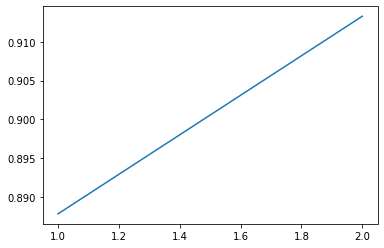

In [ ]:
network = NetworkWithCheckpointing(THREE_LAYERS, 1)
network.SGD((x_train, y_train), epochs=2, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

3 layers, checkpointing every 10th output

100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


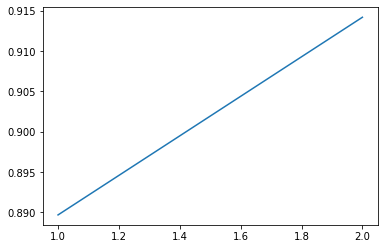

In [ ]:
network = NetworkWithCheckpointing(THREE_LAYERS, 10)
network.SGD((x_train, y_train), epochs=2, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

7 layers, checkpointing every output

100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


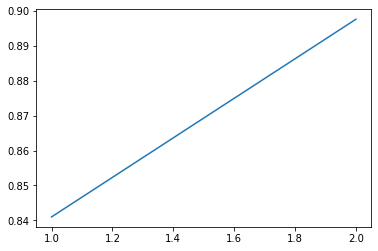

In [ ]:
network = NetworkWithCheckpointing(SEVEN_LAYERS, 1)
network.SGD((x_train, y_train), epochs=2, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

7 layers, checkpointing every second output

100%|██████████| 2/2 [00:05<00:00,  2.71s/it]


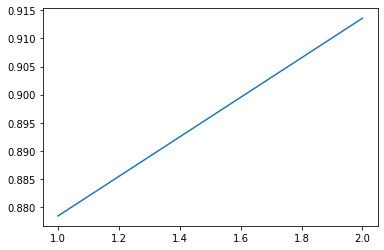

In [ ]:
network = NetworkWithCheckpointing(SEVEN_LAYERS, 2)
network.SGD((x_train, y_train), epochs=2, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

7 layers, checkpointing every 3rd output

100%|██████████| 2/2 [00:10<00:00,  5.30s/it]


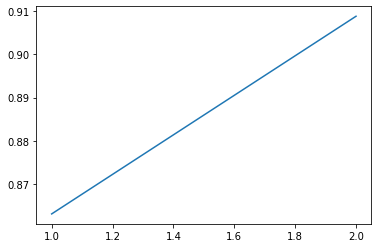

In [ ]:
network = NetworkWithCheckpointing(SEVEN_LAYERS, 3)
network.SGD((x_train, y_train), epochs=2, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

7 layers, checkpointing every 5th output

100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


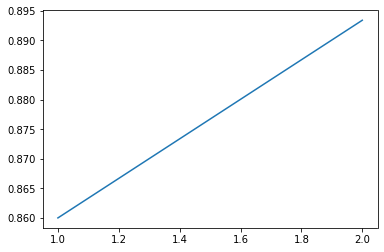

In [ ]:
network = NetworkWithCheckpointing(SEVEN_LAYERS, 5)
network.SGD((x_train, y_train), epochs=2, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

10 layers, checkpointing every 4th output

100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


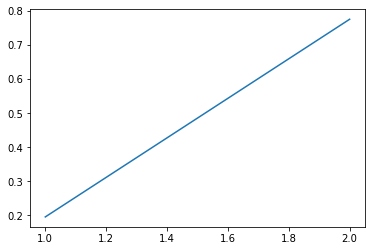

In [ ]:
network = NetworkWithCheckpointing(TEN_LAYERS, 4)
network.SGD((x_train, y_train), epochs=2, mini_batch_size=100, eta=3., test_data=(x_test, y_test))

## Test whether the checkpointing network works as expected

In [ ]:
class CacheMonitoringNetworkWithCheckpointing(NetworkWithCheckpointing):
    def __init__(self, layers, checkpoint_every_nth_layer):
        super().__init__(layers, checkpoint_every_nth_layer)
        self.visited_layers = set()

    def get_cache_keys(self):
        return list(self.cached_afters.keys())

    def cache_afters_during_forward_pass(self, after: NDArray['B, N(0), 1']):
        super().cache_afters_during_forward_pass(after)
        print("CACHE AFTER INITIALIZATION", self.get_cache_keys(), "\n")

    def get_cached_after_or_calculate(self, l):
        after = super().get_cached_after_or_calculate(l)
        # We may visit one layer twice during the backward pass,
        # during computations of parameters for consecutive layers -
        # however, after the first and up to the second query for the output of the particular layer,
        # algorithm does not modify state of the cache

        if l not in self.visited_layers:
            print("CACHE AFTER QUERY FOR: ", l, "\n", self.get_cache_keys(), "\n")
            self.visited_layers.add(l)
        return after

In [ ]:
CacheMonitoringNetworkWithCheckpointing(TEN_LAYERS, 4).SGD((x_train, y_train), epochs=1, mini_batch_size=len(x_train), eta=3., test_data=None, use_tqdm=False)

CACHE AFTER INITIALIZATION [0, 4, 8] 

CACHE AFTER QUERY FOR:  8 
 [0, 4, 8] 

CACHE AFTER QUERY FOR:  7 
 [0, 4, 5, 6, 7] 

CACHE AFTER QUERY FOR:  6 
 [0, 4, 5, 6] 

CACHE AFTER QUERY FOR:  5 
 [0, 4, 5] 

CACHE AFTER QUERY FOR:  4 
 [0, 4] 

CACHE AFTER QUERY FOR:  3 
 [0, 1, 2, 3] 

CACHE AFTER QUERY FOR:  2 
 [0, 1, 2] 

CACHE AFTER QUERY FOR:  1 
 [0, 1] 

CACHE AFTER QUERY FOR:  0 
 [0] 



We can see it does work as expected

# Comparison

## Comparison of training time

### Dense checkpointing

Three layers of shape THREE_LAYERS

In [ ]:
%%time
Network(THREE_LAYERS).SGD((x_train, y_train), epochs=10, mini_batch_size=100, eta=3., test_data=None)

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]

CPU times: user 11.9 s, sys: 11.1 s, total: 23 s
Wall time: 12.7 s


In [ ]:
%%time
NetworkWithCheckpointing(THREE_LAYERS, 2).SGD((x_train, y_train), epochs=10, mini_batch_size=100, eta=3., test_data=None)

100%|██████████| 10/10 [00:14<00:00,  1.42s/it]

CPU times: user 13.7 s, sys: 14 s, total: 27.6 s
Wall time: 14.2 s


Seven layers of shape [784, 30 x 4, 10]

In [ ]:
%%time
Network(SEVEN_LAYERS).SGD((x_train, y_train), epochs=10, mini_batch_size=100, eta=3., test_data=None)

100%|██████████| 10/10 [00:19<00:00,  1.97s/it]

CPU times: user 20.5 s, sys: 17.9 s, total: 38.4 s
Wall time: 19.7 s


In [ ]:
%%time
NetworkWithCheckpointing(SEVEN_LAYERS, 2).SGD((x_train, y_train), epochs=10, mini_batch_size=100, eta=3., test_data=None)

100%|██████████| 10/10 [00:22<00:00,  2.22s/it]

CPU times: user 19.7 s, sys: 20.1 s, total: 39.8 s
Wall time: 22.2 s


Ten layers of shape [784, 30 x 7, 10]

In [ ]:
%%time
Network(TEN_LAYERS).SGD((x_train, y_train), epochs=10, mini_batch_size=100, eta=3., test_data=None)

100%|██████████| 10/10 [00:27<00:00,  2.77s/it]

CPU times: user 28.7 s, sys: 25.3 s, total: 54 s
Wall time: 27.7 s


In [ ]:
%%time
NetworkWithCheckpointing(TEN_LAYERS, 3).SGD((x_train, y_train), epochs=10, mini_batch_size=100, eta=3., test_data=None)

100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

CPU times: user 28.2 s, sys: 25.8 s, total: 54 s
Wall time: 28.7 s


For all of the previous tests we can not see much difference between the checkpointed version and base network

### Sparse checkpointing

In [ ]:
%%time
NetworkWithCheckpointing(TEN_LAYERS, 5).SGD((x_train, y_train), epochs=10, mini_batch_size=100, eta=3., test_data=None)

100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

CPU times: user 28.2 s, sys: 26.5 s, total: 54.7 s
Wall time: 28.1 s


In the implementation of the network with checkpointing every time we encounter a layer $l$ for which we do not have outputs saved, we compute outputs for all layers starting from the layer where the nearest checkpoint resides up to the layer $l$. We cache outputs for layers between checkpoints after computing them, so we do not have to repeat the process after going to the layer before $l$.

If we checkpoint every n-th layer, an innnitial computation of checkpoints takes $O$(number_of_layers / n ) computations of outputs.
Single computation of outputs between the checkpoints takes $O$(n) computations of outputs, and it can be performed at most number_of_layers / n times.
So during the whole backpropagation we perform $O$(number_of_layers(1 + 1/n)) computations of outputs whereas the basic algorithm would perform exactly number_of_layers computations of outputs.

We can see that the solution with checkpointing is not drastically worse when it comes to computational complexity, it performs only \
$O$(number_of_layers / n) more computations of outputs.

## Comparison of memory usage

In [ ]:
def sum_nbytes_in_outputs(outputs):
    return sum(map(lambda output: output.nbytes, outputs))

class MemMonitoring():
    def __init__(self, *args, **kwargs):
        self.max_nbytes = 0

    def update_max(self, outputs):
        sum_nbytes = sum_nbytes_in_outputs(outputs)
        self.max_nbytes = max(self.max_nbytes, sum_nbytes)

    def get_max_kb(self):
        return self.max_nbytes / 1024 ** 1

class MemMonitoringNetwork(Network, MemMonitoring):
    def __init__(self, layers):
        Network.__init__(self, layers)
        MemMonitoring.__init__(self)

    def get_outputs_from_forward_pass(self, after: NDArray['B, N(0), 1']):
        # Every time we calculate outputs, we measure its cummulative size in bytes
        afters, befores = super().get_outputs_from_forward_pass(after)
        self.update_max(itertools.chain(afters, befores))
        return afters, befores

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data, use_tqdm = True):
        super().SGD(training_data, epochs, mini_batch_size, eta, test_data, use_tqdm)
        return self.get_max_kb()

class MemMonitoringNetworkWithCheckpointing(NetworkWithCheckpointing, MemMonitoring):
    def __init__(self, layers, checkpoint_every_nth_layer):
        NetworkWithCheckpointing.__init__(self, layers, checkpoint_every_nth_layer)
        MemMonitoring.__init__(self)

    def cache_afters_during_forward_pass(self, after: NDArray['B, N(0), 1']):
        super().cache_afters_during_forward_pass(after)
        self.update_max(self.cached_afters.values())

    def get_cached_after_or_calculate(self, l):
        after = super().get_cached_after_or_calculate(l)
        self.update_max(self.cached_afters.values())
        return after

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data, use_tqdm = True):
        super().SGD(training_data, epochs, mini_batch_size, eta, test_data, use_tqdm)
        return self.get_max_kb()

We measure maximal number of KiB of computed outputs for base network and cached outputs for checkpointing network.


In theory, if the base network uses M bytes of memory for saving the outputs, the checkpointing network should use\
$O$(M(1 / n +  n  / number_of_layers) / 2).
We devide by two because we store only afters, instead of afters and befores.
The (M / n) component of the sum is for the intial checkpoints,
and the (M * n / number_of_layers) component is for the additional outputs that we may cache after performing the computations of outputs between the checkpoints.
  

### Dense checkpointing

In [ ]:
def get_theoretical_approximation_of_quotient(number_of_layers, n):
    return (1.  / n  + n / number_of_layers) / 2.

Three layers of shape THREE_LAYERS

In [ ]:
base_result = MemMonitoringNetwork(THREE_LAYERS).SGD((x_train, y_train), epochs=1, mini_batch_size=100, eta=3., test_data=None)

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


In [ ]:
checkpointing_result = MemMonitoringNetworkWithCheckpointing(THREE_LAYERS, 2).SGD((x_train, y_train), epochs=1, mini_batch_size=100, eta=3., test_data=None)
checkpointing_result /  base_result, get_theoretical_approximation_of_quotient(3., 2.)

100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


(0.9421296296296297, 0.5833333333333333)

Seven layers of shape [784, 30 x 4, 10]

In [ ]:
base_result = MemMonitoringNetwork(SEVEN_LAYERS).SGD((x_train, y_train), epochs=1, mini_batch_size=100, eta=3., test_data=None)

100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


In [ ]:
checkpointing_result = MemMonitoringNetworkWithCheckpointing(SEVEN_LAYERS, 2).SGD((x_train, y_train), epochs=1, mini_batch_size=100, eta=3., test_data=None)
checkpointing_result /  base_result, get_theoretical_approximation_of_quotient(7., 2.)

100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


(0.8180076628352491, 0.39285714285714285)

Ten layers of shape [784, 30 x 7, 10]

In [ ]:
base_result = MemMonitoringNetwork(TEN_LAYERS).SGD((x_train, y_train), epochs=1, mini_batch_size=100, eta=3., test_data=None)

100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


In [ ]:
checkpointing_result = MemMonitoringNetworkWithCheckpointing(TEN_LAYERS, 1).SGD((x_train, y_train), epochs=1, mini_batch_size=100, eta=3., test_data=None)
checkpointing_result /  base_result

100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


0.8202614379084967

In [ ]:
checkpointing_result = MemMonitoringNetworkWithCheckpointing(TEN_LAYERS, 3).SGD((x_train, y_train), epochs=1, mini_batch_size=100, eta=3., test_data=None)
checkpointing_result / base_result, get_theoretical_approximation_of_quotient(10., 3.)

100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


(0.7222222222222222, 0.31666666666666665)

For all of the previous tests we can not see much difference between the checkpointed version and base network

### Sparse checkpointing

In [ ]:
checkpointing_result = MemMonitoringNetworkWithCheckpointing(TEN_LAYERS, 5).SGD((x_train, y_train), epochs=1, mini_batch_size=100, eta=3., test_data=None)
checkpointing_result / base_result, get_theoretical_approximation_of_quotient(10., 5.)

100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


(0.738562091503268, 0.35)


From the above examples we can see that the ratio of\
sizeof(cached_outputs) / sizeof(computed_outputs) was the least for the TEN_LAYERS, n = 3 setting.

Overall results of our analysis are worrying, either our approximation of the expected quotient is not perfect or we do not measure the memory usage precisely enough.